# 2-3 Improve Image Classification
>ResNet
- Residual block
- batch normalization

In [1]:
import keras
from keras import layers

inputs = layers.Input(shape=(224, 224, 3))
x = layers.ZeroPadding2D(padding=3)(inputs)
x = layers.Conv2D(64, 7, strides=2)(x)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)

/Users/jameshoyu/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
x = layers.ZeroPadding2D(padding=1)(x)
x = layers.MaxPooling2D(3, strides=2)(x)

## Residual Stack

In [3]:
def build_stack(x):
    # 첫 번째 잔차 스택의 첫 번째 잔차 블록만 스트라이드 1을 사용합니다
    x = residual_stack(x, 3, 64, first_stride=1)
    # 두 번째~네 번째 잔차 블록을 만듭니다
    for blocks, filters in [(4, 128), (6, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters, first_stride=2)
    return x

def residual_stack(x, blocks, filters, first_stride=2):
    # 첫 번째 잔차 블록은 합성곱 스킵 연결을 사용하고
    # 이 잔차 블록의 첫 번째 합성곱 스트라이드는 first_stride입니다.
    x = residual_block(x, filters, first_stride=first_stride, conv_skip=True)
    for _ in range(1, blocks):
        # 나머지 잔차 블록의 첫 번째 합성곱 스트라이드는 1입니다.
        x = residual_block(x, filters, first_stride=1, conv_skip=False)
    return x

In [4]:
def residual_block(x, filters, first_stride=1, conv_skip=False):
    skip_conn = x
    # 합성곱과 배치 정규화, 렐루 활성화 함수를 반복합니다
    # 1x1, filters개 필터, 스트라이드는 first_stride에 따라 1 또는 2
    x = layers.Conv2D(filters=filters, kernel_size=1,
                      strides=first_stride)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    # 3x3, filters개 필터
    x = layers.Conv2D(filters=filters, kernel_size=3,
                      padding='same')(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    # 1x1, filters*4개 필터
    x = layers.Conv2D(filters=filters*4, kernel_size=1)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    # conv_skip이 True이면 1x1 합성곱을 사용해 채널 크기를 filters*4로 늘립니다
    if conv_skip == True:
        skip_conn = layers.Conv2D(filters=filters*4, kernel_size=1,
                                  strides=first_stride)(skip_conn)
        skip_conn = layers.BatchNormalization(epsilon=1e-5)(skip_conn)
    x = layers.Add()([skip_conn, x])
    x = layers.Activation('relu')(x)
    return x

## ResNet Model

In [5]:
x = build_stack(x)

In [11]:
print(x.shape)

(None, 2048)


In [9]:
# global pooling layer
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1000, activation='softmax')(x)

In [10]:
model = keras.Model(inputs, outputs)

In [12]:
def build_stack101(x):
    # 첫 번째 잔차 스택의 첫 번째 잔차 블록만 스트라이드 1을 사용합니다
    x = residual_stack(x, 3, 64, first_stride=1)
    # 두 번째~네 번째 잔차 블록을 만듭니다
    for blocks, filters in [(4, 128), (23, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters, first_stride=2)
    return x

In [13]:
def build_stack152(x):
    # 첫 번째 잔차 스택의 첫 번째 잔차 블록만 스트라이드 1을 사용합니다
    x = residual_stack(x, 3, 64, first_stride=1)
    # 두 번째~네 번째 잔차 블록을 만듭니다
    for blocks, filters in [(8, 128), (36, 256), (3, 512)]:
        x = residual_stack(x, blocks, filters, first_stride=2)
    return x

In [17]:
# !python3 -m pip install gdown

In [16]:
# !gdown 1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
# !unzip cat-dog-images.zip

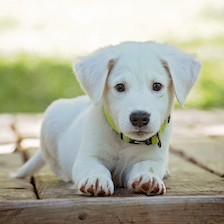

In [26]:
from PIL import Image
import numpy as np
from keras.applications import resnet

dog_png = Image.open('images/dog.png')
display(dog_png)
resnet_prep_dog = resnet.preprocess_input(np.array(dog_png))

In [20]:
resnet50 = keras.applications.ResNet50()
predictions = resnet50.predict(resnet_prep_dog[np.newaxis,:])

resnet.decode_predictions(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


[[('n02099712', 'Labrador_retriever', np.float32(0.38535213)),
  ('n02099601', 'golden_retriever', np.float32(0.089699864)),
  ('n02100735', 'English_setter', np.float32(0.042124234)),
  ('n02106166', 'Border_collie', np.float32(0.03777438)),
  ('n02101388', 'Brittany_spaniel', np.float32(0.03070047))]]

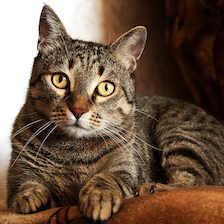

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[[('n02123045', 'tabby', np.float32(0.8686101)),
  ('n02124075', 'Egyptian_cat', np.float32(0.05077487)),
  ('n02123159', 'tiger_cat', np.float32(0.04256713)),
  ('n07930864', 'cup', np.float32(0.0027631565)),
  ('n03443371', 'goblet', np.float32(0.0020991687))]]

In [25]:
cat_png = Image.open('images/cat.png')
display(cat_png)
resnet_prep_cat = resnet.preprocess_input(np.array(cat_png))
predictions = resnet50.predict(resnet_prep_cat[np.newaxis,:])

resnet.decode_predictions(predictions)

## Mini Project

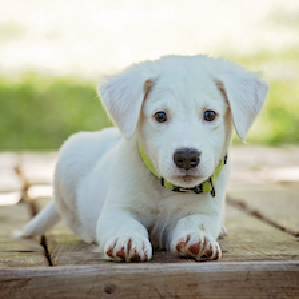

In [32]:
from keras.utils import load_img
from keras.applications import inception_v3

dog_png = load_img("images/dog.png", target_size=(299, 299))
incep_prep_dog = inception_v3.preprocess_input(np.array(dog_png))
display(dog_png)

In [31]:
inception = keras.applications.InceptionV3()
predictions = inception.predict(incep_prep_dog[np.newaxis,:])
inception_v3.decode_predictions(predictions)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


[[('n02104029', 'kuvasz', np.float32(0.13835095)),
  ('n02099712', 'Labrador_retriever', np.float32(0.077772595)),
  ('n02106166', 'Border_collie', np.float32(0.071983404)),
  ('n02111500', 'Great_Pyrenees', np.float32(0.06614933)),
  ('n02099601', 'golden_retriever', np.float32(0.028383372))]]

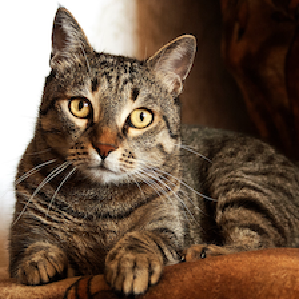

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[[('n02124075', 'Egyptian_cat', np.float32(0.68673664)),
  ('n02123159', 'tiger_cat', np.float32(0.13263004)),
  ('n02123045', 'tabby', np.float32(0.042150345)),
  ('n04040759', 'radiator', np.float32(0.0016103366)),
  ('n02971356', 'carton', np.float32(0.0011297774))]]

In [34]:
cat_png = load_img("images/cat.png", target_size=(299, 299))
display(cat_png)
incept_prep_cat = inception_v3.preprocess_input(np.array(cat_png))
predictions = inception.predict(incept_prep_cat[np.newaxis,:])
inception_v3.decode_predictions(predictions)

In [36]:
# Inception-ResNet model
from keras.applications import inception_resnet_v2 as incep_res_v2

incept_res_prep_dog = incep_res_v2.preprocess_input(np.array(dog_png))
inception_resnet = keras.applications.InceptionResNetV2()
predictions = inception_resnet.predict(incept_res_prep_dog[np.newaxis,:])
incep_res_v2.decode_predictions(predictions)

225209952/225209952 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[[('n02099712', 'Labrador_retriever', np.float32(0.6563331)),
  ('n02104029', 'kuvasz', np.float32(0.13956212)),
  ('n02099601', 'golden_retriever', np.float32(0.055945132)),
  ('n02111500', 'Great_Pyrenees', np.float32(0.04889469)),
  ('n02100735', 'English_setter', np.float32(0.0021178762))]]

In [37]:
incep_res_prep_cat = incep_res_v2.preprocess_input(np.array(cat_png))
predictions = inception_resnet.predict(incep_res_prep_cat[np.newaxis,:])
incep_res_v2.decode_predictions(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


[[('n02123045', 'tabby', np.float32(0.42494923)),
  ('n02124075', 'Egyptian_cat', np.float32(0.25830922)),
  ('n02123159', 'tiger_cat', np.float32(0.12795249)),
  ('n02127052', 'lynx', np.float32(0.0034486125)),
  ('n04525038', 'velvet', np.float32(0.002446104))]]